# Medical Image Segmentation - PDE, Deformable or Contour based methods 

#### In order to complete this laboratory task you should review the instruction file (Lab4_3 Instruction.pdf) beforehand. 

## TASK2) Region-Based Energy

#### The whole framework is exactly as previous task; however, instead of using a constant data-drive energy, we are going to implement a region-based method using global image statistics. The goal is to segment lung region.

In [17]:
# just for read
import cv2 # image processing and machine vision package
import numpy as np
from scipy import interpolate as ip
import matplotlib.pyplot as plt
from scipy.interpolate import spline
import scipy.ndimage as nd
from Functions2 import *

In [18]:
# Just for read.
# function for setting the points on the image and creating a mask.

refPt = [] # Selected points by user
flag = True # for right click checking

def Mask_Generator(shape,interpX,interpY): # Generate edge(mask) and filled(mask2) Masks
        mask = np.zeros(shape)
        for i in range(len(interpX)):
                mask[interpX[i],interpY[i]]=1
        a,b = shape
        mask2 = np.zeros(shape)
        for i in range(a):
                MaskRow = mask[i,:]
                Index = np.where(MaskRow==1)[0]
                if len(Index)==0:
                        continue
                SIndex = Index[0] # First index of ones from left
                EIndex = Index[-1]# First index of ones from right
                for j in range(SIndex,EIndex): # Fill between them!
                        mask2[i,j]=1
        return (mask,mask2)
# Open the image window for mouse clicks (for click_and_crop function)and as soon as flag gets false this will close the image window
def Selection(imageC):
        global refPt
        while flag:
                cv2.imshow('image', imageC)
                key = cv2.waitKey(10) & 0xFF
                if key == ord("z"): # break the loop if 'z' pressed. not necessary
                        break
def click_and_crop(event, x, y, flags, param): # event handler of clicks
        global refPt,flag,image
        if (event == cv2.EVENT_LBUTTONDOWN): # if left click:
                refPt.append((y, x))
                cv2.circle(imageC,(x,y),3,(255,0,0),-1)
        elif (event == cv2.EVENT_RBUTTONDOWN): # if right click:
                refPt.append((y, x))
                cv2.circle(imageC,(x,y),5,(0,255,255),-1)
                flag=False

In [19]:
# Just for read.
# Here we load the input image (a CT lung image) and select some arbitrary points to create a mask as initial contour.
# The output mask is which will be employed as initial contour named as "init_mask"
imgname = 'Echo.jpg'
image = cv2.imread(imgname,0) # grayscale for process
imageC = cv2.imread(imgname)  # color for presentation
cv2.namedWindow("image")
cv2.setMouseCallback("image", click_and_crop)
Selection(imageC)
points = np.asarray(refPt)
LXs = points[:,0] # x of first selection
LXt = list(LXs)
LXt.append(points[0,0]) # add the first points to the end of the list for create circular structure
LXs = np.asarray(LXt)
LYs = points[:,1]
LYt = list(LYs)
LYt.append(points[0,1])
LYs = np.asarray(LYt)
tckL,uL = ip.splprep( [LXs,LYs] ,k=3 )
xnewL,ynewL = ip.splev( np.linspace( 0, 1, 1600 ), tckL,der = 0)
rounded_xnewL = np.int64(np.round_(xnewL))
rounded_ynewL = np.int64(np.round_(ynewL))
(lm,init_mask) = Mask_Generator(image.shape,rounded_xnewL,rounded_ynewL)

In [20]:
# TODOs
eps = np.finfo(float).eps # set a very small number(to prevent dividing by zero)
I = nd.imread('Echo.jpg', flatten=True)   #  read image for segmentation
I = I.astype(np.float)
# TODO set a maximum number of iteration
max_its= 20
display=True
# TODO set the coefficient of curvature term
alpha= 10
color='g'
# TODO: set a threshold value for stopping criteria
thresh = 0.1

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


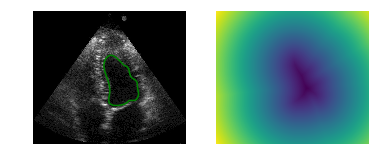

In [21]:
# just for read
# Create a signed distance map (SDF) from mask
phi = mask2phi(init_mask)
# intermediate plotting
if display:
    plt.ion()
    fig, axes = plt.subplots(ncols=2)
    show_curve_and_phi(fig, I, phi, color)

In [22]:
# just for read
# Main loop
its = 0
stop = False
prev_mask = init_mask
c = 0

iteration: 0


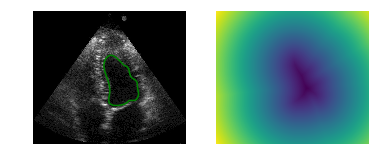

In [23]:
# TODOs:
while (its < max_its and not stop):
    # Get the curve's narrow band
    idx = np.flatnonzero(np.logical_and(phi <= 1.2, phi >= -1.2))

    if len(idx) > 0:
        # Intermediate output
        if display:
            if np.mod(its, 500) == 0:
                plt.ion()
                fig, axes = plt.subplots(ncols=2)
                print('iteration: {0}'.format(its))
                show_curve_and_phi(fig, I, phi, color)
        else:
            if np.mod(its, 10) == 0:
                print('iteration: {0}'.format(its))

        
        # TODOs:
        # Finding the points inside the contour
        upts = np.flatnonzero(phi <= 0) 
        # TODO: Finding the points outside the contour
        vpts =  np.flatnonzero(phi > 0)
        # Calculating average intensity inside the contour
        u = np.sum(I.flat[upts]) / (len(upts) + eps)
        # TODO: Calculate average intensity outside the contour
        v = np.sum(I.flat[vpts]) / (len(vpts) + eps)

        # TODO: calculate the data drive energy and name it as "F"
        flat_im=np.ndarray.flatten(I)
        F = (I.flat[idx]-v)**2-(I.flat[idx]-u)**2
        
        # Force from curvature penalty
        curvature = get_curvature(phi, idx)

        # Complete energy term
        dphidt = F / np.max(np.abs(F)) + alpha * curvature

        # Maintain the Courant–Friedrichs–Lewy (CFL) condition 
        dt = 0.45 / (np.max(np.abs(dphidt)) + eps)

        # TODO: update the level set function only in the narrowband points such as X = X+dt*energy functional
        phi.flat[idx] +=dt*dphidt

        # Keep SDF smooth (Re-initialization process)
        phi = sussman(phi, 0.5)

        new_mask = phi <= 0
        c = convergence(prev_mask, new_mask, thresh, c)

        if c <= 5:
            its = its + 1
            prev_mask = new_mask
        else:
            stop = True

    else:
        break

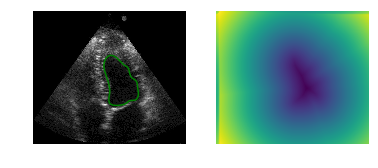

In [24]:
# Final output
if display:
    plt.ion()
    fig, axes = plt.subplots(ncols=2)
    show_curve_and_phi(fig, I, phi, color)

# Make mask from SDF
seg = phi <= 0  # Get mask from levelset

In [ ]:
# TODO:
# Please repeat the whole process for other images (Brain,Pelv and Echo)
# Answer these questions:
# What is the role of thresh parameter? The threshold defines the stop condition for a curve to stop changing. If the variation is smaller than the threshold, there is convergence and then the algorithm is stopped
# How initial contour effects on the final result? The final result is highly dependent on the initial contour, being one of the disadvantages of level-set segmentation methods
# How the smoothing coefficient (alpha) effects on final reslut? An increasing alpha restricts the curvature changes, so that it does not change so much